In [2]:
# THe Harr Measure
# operations in quantum computing are described by unitary matrices. 
# these matrices can be expressed in terms of a fixed set of coordinates or params
# for an N-dim system, the Harr measure, i.e. \mu_N tells us how to weight the elmts of U(N)

# example:
    # let f be a function that acts on elements of U(N), and we want to take its integral over the group
    # we write this integral with rsp to the Haar measure:
    # \int_{V \in U(N)} f(V) d \mu_N (V)

#single qubit Haar measure: provides a recipe for sampling elements of the unitary group
# in a properly uniform manner: i.e. provides a method to sample quantums tates uniformly at random
    # simply generate Haar random unitaries and apply them to a fixed basis state (|0>)

In [3]:
%pip install pennylane


Note: you may need to restart the kernel to use updated packages.


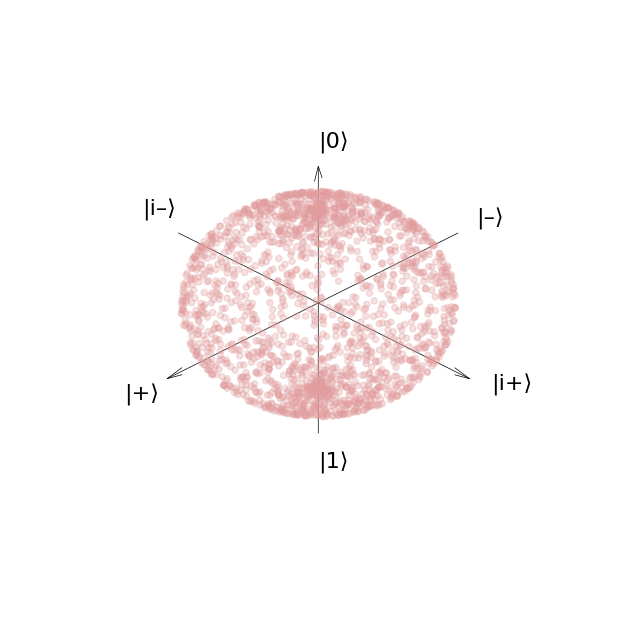

In [4]:
# Let us begin by looking at what happens when we ignore the measure and do things WRONG
    # suppose we sample quantum states by applying unitaries obtained by the parametrization,
    #  but sample the angles from the flat uniform distribution

import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# set the random seed
np.random.seed(42)

# Use the mixed state simulator to save some steps in plotting later
dev = qml.device('default.mixed', wires=1)

@qml.qnode(dev)
def not_a_haar_random_unitary():
    # Sample all parameters from their flat uniform distribution
    phi, theta, omega = 2 * np.pi * np.random.uniform(size=3)
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

num_samples = 2021

not_haar_samples = [not_a_haar_random_unitary() for _ in range(num_samples)]
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Used the mixed state simulator so we could have the density matrix for this part!
def convert_to_bloch_vector(rho):
    """Convert a density matrix to a Bloch vector."""
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

not_haar_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in not_haar_samples])

# with this done, let's find out where our "uniformly random" states ended up

def plot_bloch_sphere(bloch_vectors):
    """ Helper function to plot vectors on a sphere."""
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)

    # Draw the axes (source: https://github.com/matplotlib/matplotlib/issues/13575)
    x, y, z = np.array([[-1.5,0,0], [0,-1.5,0], [0,0,-1.5]])
    u, v, w = np.array([[3,0,0], [0,3,0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(
        bloch_vectors[:,0], bloch_vectors[:,1], bloch_vectors[:, 2], c='#e29d9e', alpha=0.3
    )
    plt.show()

plot_bloch_sphere(not_haar_bloch_vectors)

# you can clearly tell from the plot that even though the params were sampled from a uniform dist,
# there is a noticible amount of clustering around the poles of the sphere.

In [5]:
# for a single qubit, the Haar measure looks much like the case of a sphere, minus the radial component. 
# Intuitively, all qubit state vectors have length 1, so it makes sense that this wouldn't matter.
# the param that we have to weight differently is theta, we must scale by sin theta
# we accomplish this by setting up a custom probability distribution with rv_continous

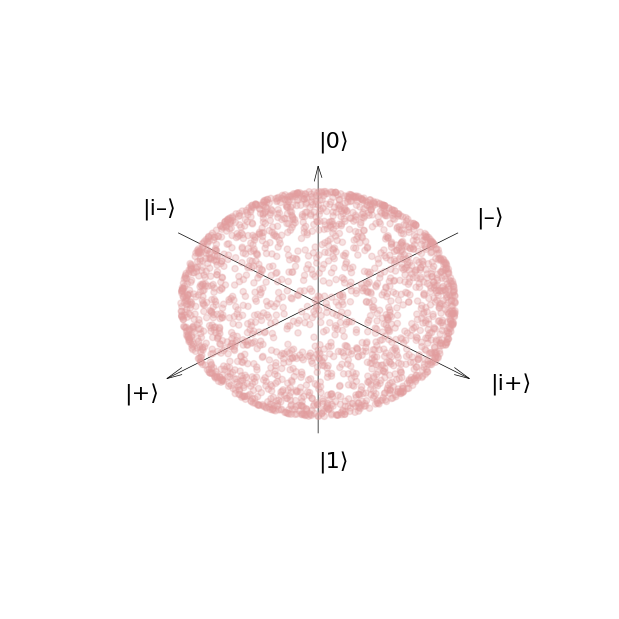

In [6]:
from scipy.stats import rv_continuous

class sin_prob_dist(rv_continuous):
    def _pdf(self, theta):
        # The 0.5 is so that the distribution is normalized
        return 0.5 * np.sin(theta)

# Samples of theta should be drawn from between 0 and pi
sin_sampler = sin_prob_dist(a=0, b=np.pi)

@qml.qnode(dev)
def haar_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2) # Sample phi and omega as normal
    theta = sin_sampler.rvs(size=1)[0]  # Sample theta from our new distribution
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

haar_samples = [haar_random_unitary() for _ in range(num_samples)]
haar_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in haar_samples])

plot_bloch_sphere(haar_bloch_vectors)

# we see that now, our qubit states are much better distributed over the sphere. 

In [7]:
# We can now obtain the explicit form for the single qubit Haar measure:
# d \mu_2 =  \sin \theta d \theta \cdot dw \cdot d \thi

# while we can easily visualize the single qubit case, this is no longer possible when we increase the number of qubits
# we can still obtain a mathematical expression for the Haar measure in arbitrary dimensions

# Define SU(N): the special unitary group - the continous group consisting of all N x N unitary operators with det = 1

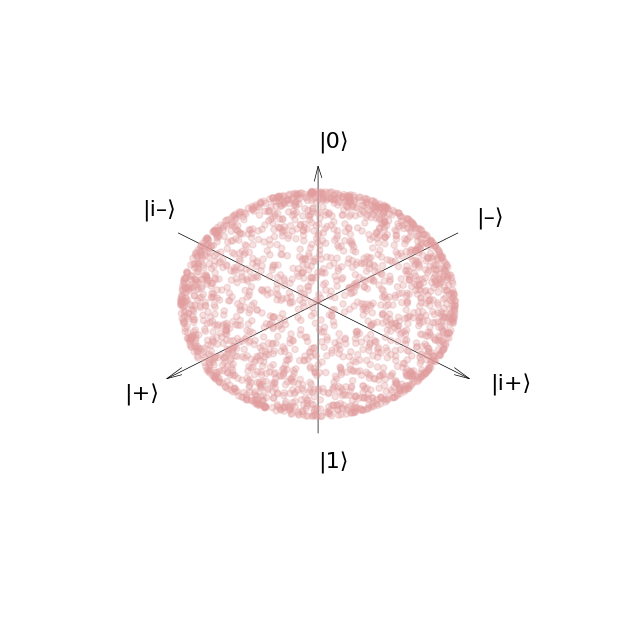

In [8]:
# Haar-random matrices from the QR decomposition

# when we need to generate a large number of high dimensional Haar-random matrices,
# it is difficult to keep track of so many params. Thus, we must take a QR decomposition of complex valued matrices.

# Generate an N x N matrix Z with complex numbers: a + bi where a and b are normally distributed with mean and variance 1
#Compute a QR decomposition: Z = QR
# compute the diagonal matrix V = diag(R_II/|R_ii|)
# compute Q' = QV, which will be Haar-random

from numpy.linalg import qr

def qr_haar(N):
    """Generate a Haar-random matrix using the QR decomposition."""
    # Step 1
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    # Step 2
    Q, R = qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    # Step 4
    return np.dot(Q, Lambda)

@qml.qnode(dev)
def qr_haar_random_unitary():
    qml.QubitUnitary(qr_haar(2), wires=0)
    return qml.state()

qr_haar_samples = [qr_haar_random_unitary() for _ in range(num_samples)]
qr_haar_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in qr_haar_samples])
plot_bloch_sphere(qr_haar_bloch_vectors)

In [9]:
# TASK 01: calculate expectation value of < psi | X^(tensor n) | psi >

#note: already have qr_haar defined: generates a haar-random unitary matrix using QR decomp


def tensor_n(A, n):
    X_n = A
    for _ in range(n-1):
        X_n = np.kron(X_n, A)  # Correctly build the tensor product
    return X_n  

def calc(Op, U, n):
    # calculate the product <0 | U^dag X^tensor n U|0>
    q_0 = np.array([1, 0])  # basis |0> state
    q_0n = tensor_n(q_0, n)  # Ensure column vector
    Operator = tensor_n(Op, n)
    U_dag = U.conj().T
    q_0dag = q_0n.conj().T
    return (q_0dag @ U_dag @ Operator @ U @ q_0n) # ensures that to_return is not a 1 by 1 matrix but a number
    

def estimate_expectation(Op, n, num_samples=1000):
    
    exp_values = [calc(Op, qr_haar(2**n), n) for _ in range(num_samples)]
    return np.mean(exp_values)

# Example: Estimate for n=3 qubits
n = 2
num_samples = 10000  # Increase for better accuracy
X = np.array([[0, 1], [1, 0]])  # Single-qubit Pauli X
I = np.array([[1,0],[0,1]]) # should have E = 1?
Z = np.array([[1, 0], [0, -1]])
o = np.array([[1,0],[0,0]])
expected_value = estimate_expectation(X, n, num_samples)
expected_value_id = estimate_expectation(I, n, num_samples)
expected_value_Z = estimate_expectation(Z, n, num_samples)
expected_value_o = estimate_expectation(o, n, num_samples)
print(f"Estimated E[⟨ψ | I^{n} | ψ ⟩] for n={n}: {expected_value_id:.6f}")
print(f"Estimated E[⟨ψ | X^{n} | ψ ⟩] for n={n}: {expected_value:.6f}")
print(f"Estimated E[⟨ψ | Z^{n} | ψ ⟩] for n={n}: {expected_value_Z:.6f}")






Estimated E[⟨ψ | I^2 | ψ ⟩] for n=2: 1.000000+0.000000j
Estimated E[⟨ψ | X^2 | ψ ⟩] for n=2: 0.004759-0.000000j
Estimated E[⟨ψ | Z^2 | ψ ⟩] for n=2: 0.001438-0.000000j
